In [1]:
import h5py
import numpy as np
from sklearn.decomposition import NMF
from timebudget import timebudget

from sourcesep.utils.config import load_config
from sourcesep.utils.compute import perm_avgabscorr

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=0.8)
%config InlineBackend.figure_format='retina'

def df_over_f(x):
    mean_x = np.mean(x)
    return (x - mean_x)/mean_x

def standardize(x):
    mean_x = np.mean(x)
    std_x = np.std(x)
    return (x - mean_x)/std_x

paths = load_config(dataset_key='all')
h5f = h5py.File(paths['root'] / 'sims' / '2023-03-08.h5', 'r')

Paths are for dataset tagged: all


In [2]:
def get_data(f):
    """Loads arrays from pre-calculated simulation data.
    f: h5py file pointer
    """
    O = f['O'][:]
    A = f['A'][:]
    L_arr = f['L_arr'][:]

    O = O.reshape(O.shape[0],-1)

    Wij  = f['W'][:]
    Sil = f['S'][:]

    Mjl = np.einsum('ij,il->ijl', Wij, Sil)
    Mjl = Mjl.reshape(3, -1)
    M = Mjl.T.copy()

    # Noise free observation
    O_simple = M@A.T
    O_simple = O_simple.T
    return O, O_simple,A, M, L_arr


def plot_components(H_true, H_pred):
    '''
    Plots the components of the NMF model.

    Args:
        H_true: true components shaped as (n_indicators, n_timesamples)
        H_pred: predicted components shaped as (n_indicators, n_timesamples)
    '''
    perm, corr = perm_avgabscorr(H_pred.T, H_true.T)
    best_perm = perm[np.argmax(corr)]
    print(f'correlation: {np.max(corr):.2f}')

    fig, ax = plt.subplots(3, 1, figsize=(6, 6))
    for i in range(3):
        ax[i].plot(standardize(H_pred[best_perm[i], :]),
                   alpha=0.8, c='r', label='pred (standardized)')
        ax[i].plot(standardize(H_true[i, :]), alpha=0.3,
                   c='b', label='true (standardized)')
        ax[i].set(xlabel='time samples', ylabel='amplitude', xlim=(0, 1000))

    plt.legend()
    plt.show()
    return fig, ax


# refactor plot_mixing to call W as W_pred and M as W_true
def plot_mixing(L_arr, W_true, W_pred, n_lasers=5, n_factors=3):
    '''
    Plots the mixing matrix for each laser.

    Args:
        L_arr: array of wavelengths
        W_true: true mixing matrix shaped as (n_channels, n_indicators)
        W_pred: predicted mixing matrix shaped as (n_channels, n_indicators)
    '''
    fig, ax = plt.subplots(5, 2, figsize=(7, 6))
    W_pred = W_pred / (np.sum(W_pred, axis=0, keepdims=True) + 1e-10)

    for laser in range(n_lasers):
        idx = np.arange(L_arr.size)*laser
        for factor in range(n_factors):
            ax[laser, 0].plot(L_arr, W_pred[idx, factor])

    for laser in range(n_lasers):
        idx = np.arange(L_arr.size)*laser
        for factor in range(n_factors):
            ax[laser, 1].plot(L_arr, W_true[idx, factor])

    ax[n_lasers-1, 0].set(xlabel='wavelengths', ylabel='fitted mixing')
    ax[n_lasers-1, 1].set(xlabel='wavelengths', ylabel='imposed mixing')
    for laser in range(n_lasers):
        ax[laser, 0].set_title('Predicted')
        ax[laser, 1].set_title('True')
    plt.tight_layout()
    return fig, ax


In [3]:
O_noisy, O_simple, H_true, W_true, L_arr = get_data(h5f)

O_noisy = O_noisy.T
O_simple = O_simple.T
H_true = H_true.T

# print all the shapes in the format name, (x,y))
print(f'O_noisy: {O_noisy.shape}')
print(f'O_simple: {O_simple.shape}')
print(f'H_true: {H_true.shape}')
print(f'W_true: {W_true.shape}')
print(f'L_arr: {L_arr.shape}')

O_noisy: (300, 216000)
O_simple: (300, 216000)
H_true: (3, 216000)
W_true: (300, 3)
L_arr: (60,)


/home/rohan/miniconda3/envs/sourcesep2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(


correlation: 1.00


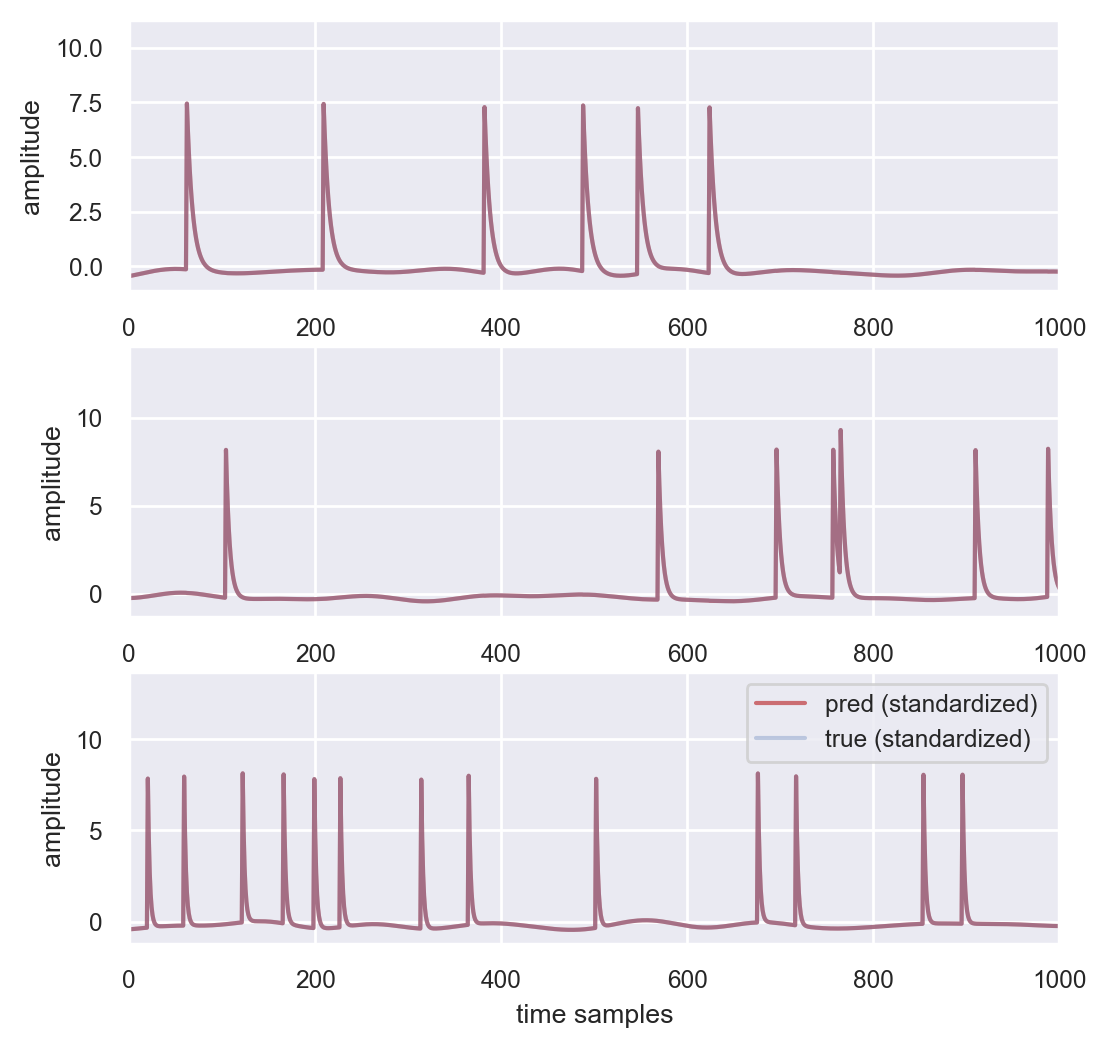

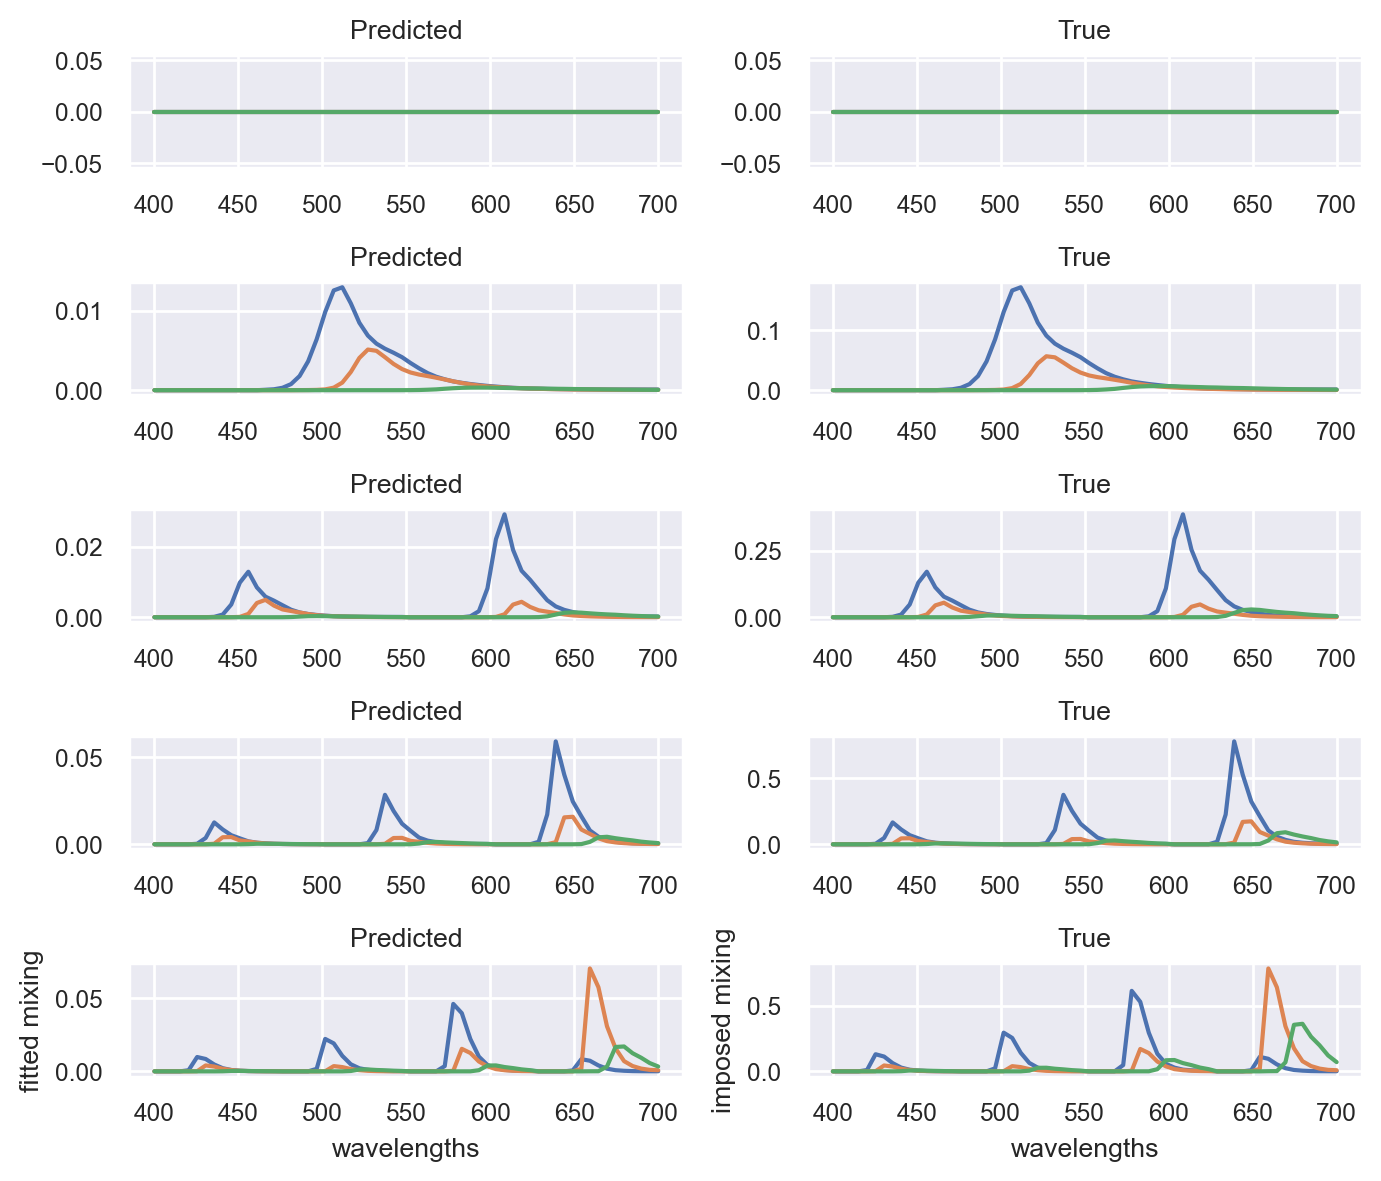

avg. L1 error: 0.00000041
avg. L2 error: 0.00000000


In [4]:
# Example with initializing W to the correct value
W_init = W_true.copy()
H_init = np.random.rand(W_init.shape[1],O_simple.shape[1]) + 2.0

scale_factor = 1e1
t_start=0
t_end=20000
H_init = H_init[:,t_start:t_end]

model = NMF(n_components=3, init='custom',
            solver='mu', beta_loss='frobenius',
            tol=1e-10, max_iter=5000, random_state=None,
            alpha_W=0.0, alpha_H=0, l1_ratio=0.0,
            verbose=0, shuffle=False)

W_pred = model.fit_transform(O_simple[:,t_start:t_end]*scale_factor, W=W_init, H=H_init)
H_pred = model.components_

fig, ax = plot_components(H_true[:,t_start:t_end], H_pred)
fig, ax = plot_mixing(L_arr, W_true, W_pred)
plt.show()

# errors
err = (O_simple[:,t_start:t_end]*scale_factor - W_pred@H_pred)/scale_factor
print(f'avg. L1 error: {np.mean(np.abs(err)):.8f}')
print(f'avg. L2 error: {np.mean(np.abs(err**2)):.8f}')
assert np.allclose(W_true@H_true[:,t_start:t_end], O_simple[:,t_start:t_end], atol=1e-7), 'data not recovered'

In [5]:
import torch

W_init = W_true.copy()
H_means = np.mean(H_true, axis=1, keepdims=True)
H_std = np.std(H_true, axis=1, keepdims=True)
H_init = np.broadcast_to(H_means, H_true.shape) + np.random.randn(*H_true.shape)*0.01 
print(f'std of H_true: {H_std}')

scale_factor = 1.0
t_start=0
t_end=2000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Ot = torch.as_tensor(O_simple[:,t_start:t_end]*scale_factor).to(device)
Wt_pred = torch.as_tensor(W_init).to(device)
Ht_pred = torch.tensor(H_init[:,t_start:t_end]*scale_factor).to(device)
Ht_pred.requires_grad = True

std of H_true: [[0.013093  ]
 [0.01147837]
 [0.01249981]]


In [6]:
optimizer = torch.optim.Adam([Ht_pred], lr=1e-3)
loss_fn = torch.nn.SmoothL1Loss(beta = 2*np.mean(H_std))
loss_history = []
n_iter = 1000
for i in range(n_iter):
    loss = loss_fn(Ot, Wt_pred@Ht_pred)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_history.append(loss.item())
    if (i+1) % 200 == 0:
        print(f'step: {i+1:5d}, avg. L1 loss: {loss.item():0.8f}')

step:   200, avg. L1 loss: 0.00000000
step:   400, avg. L1 loss: 0.00000000
step:   600, avg. L1 loss: 0.00000000
step:   800, avg. L1 loss: 0.00000000
step:  1000, avg. L1 loss: 0.00000000


correlation: 1.00


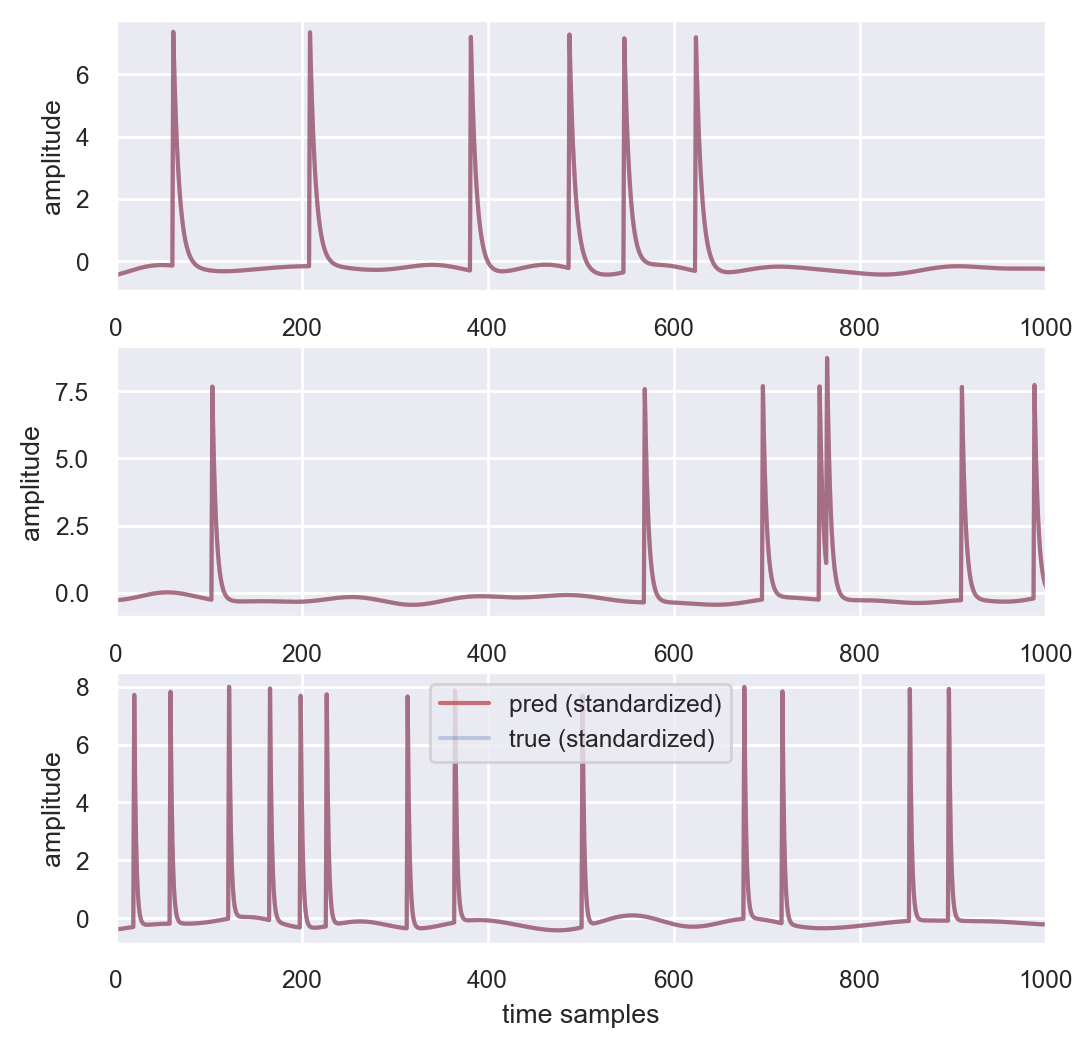

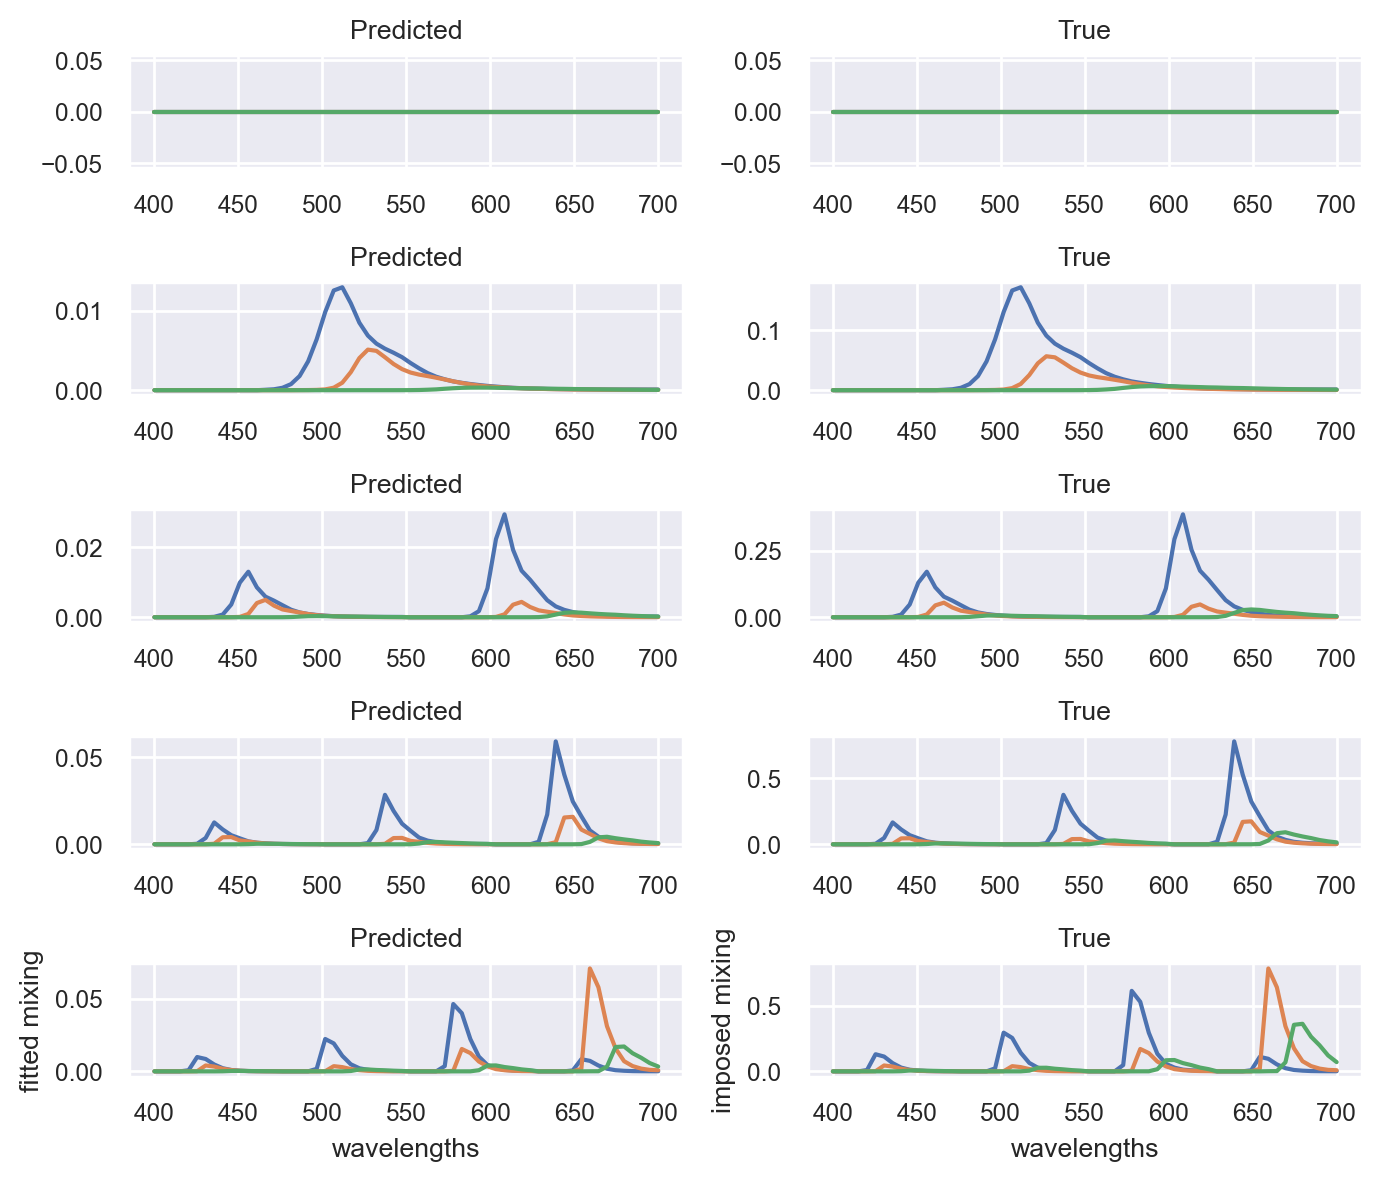

avg. L1 error: 0.00000000
avg. L2 error: 0.00000000


In [7]:
W_pred = Wt_pred.cpu().detach().numpy()
H_pred = Ht_pred.cpu().detach().numpy()

fig, ax = plot_components(H_true[:,t_start:t_end], H_pred)
fig, ax = plot_mixing(L_arr, W_true, W_pred)
plt.show()

# errors
err = (O_simple[:,t_start:t_end]*scale_factor - W_pred@H_pred)/scale_factor
print(f'avg. L1 error: {np.mean(np.abs(err)):.8f}')
print(f'avg. L2 error: {np.mean(np.abs(err**2)):.8f}')
assert np.allclose(W_true@H_true[:,t_start:t_end], O_simple[:,t_start:t_end], atol=1e-7), 'data not recovered'

Fitting took 120.621sec


/home/rohan/miniconda3/envs/sourcesep2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


correlation: 0.73


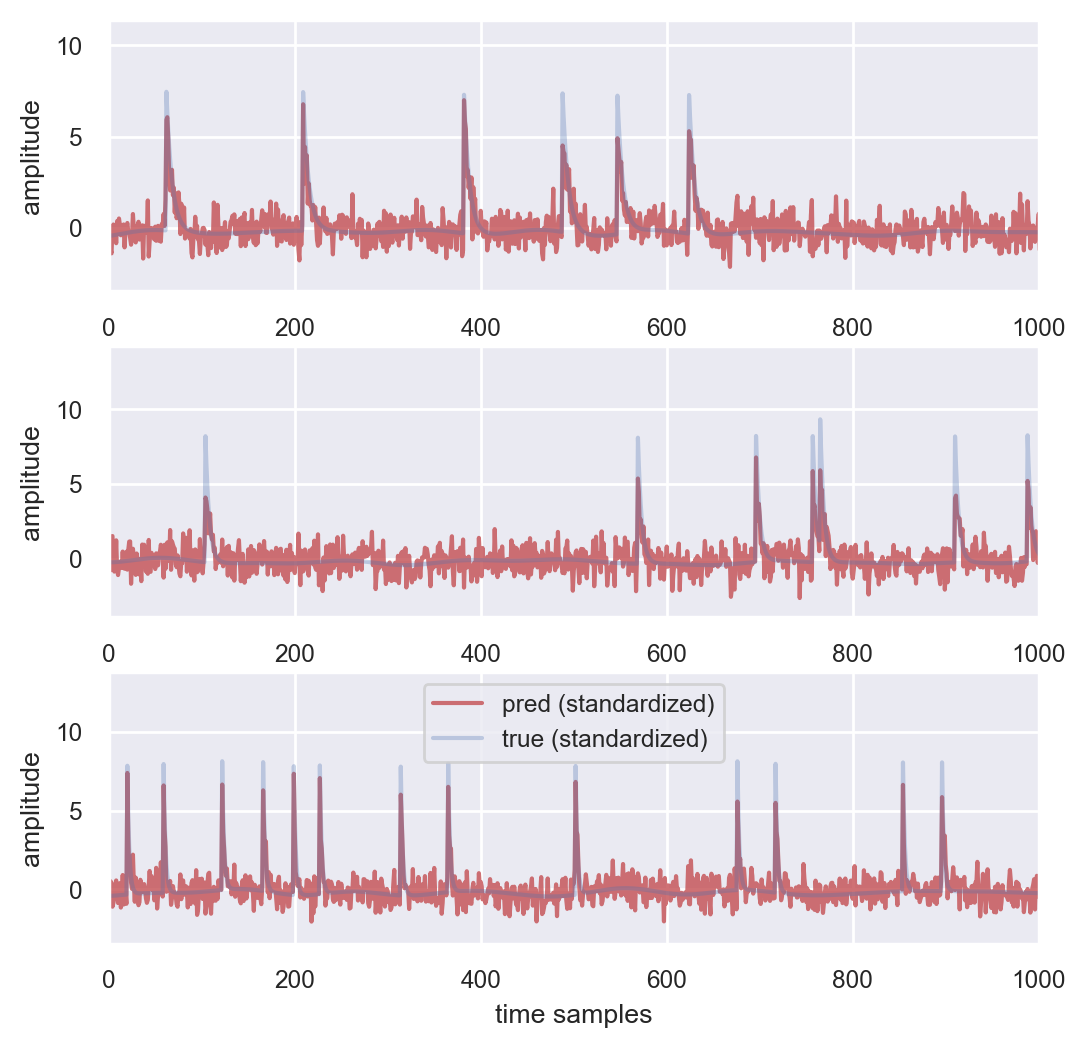

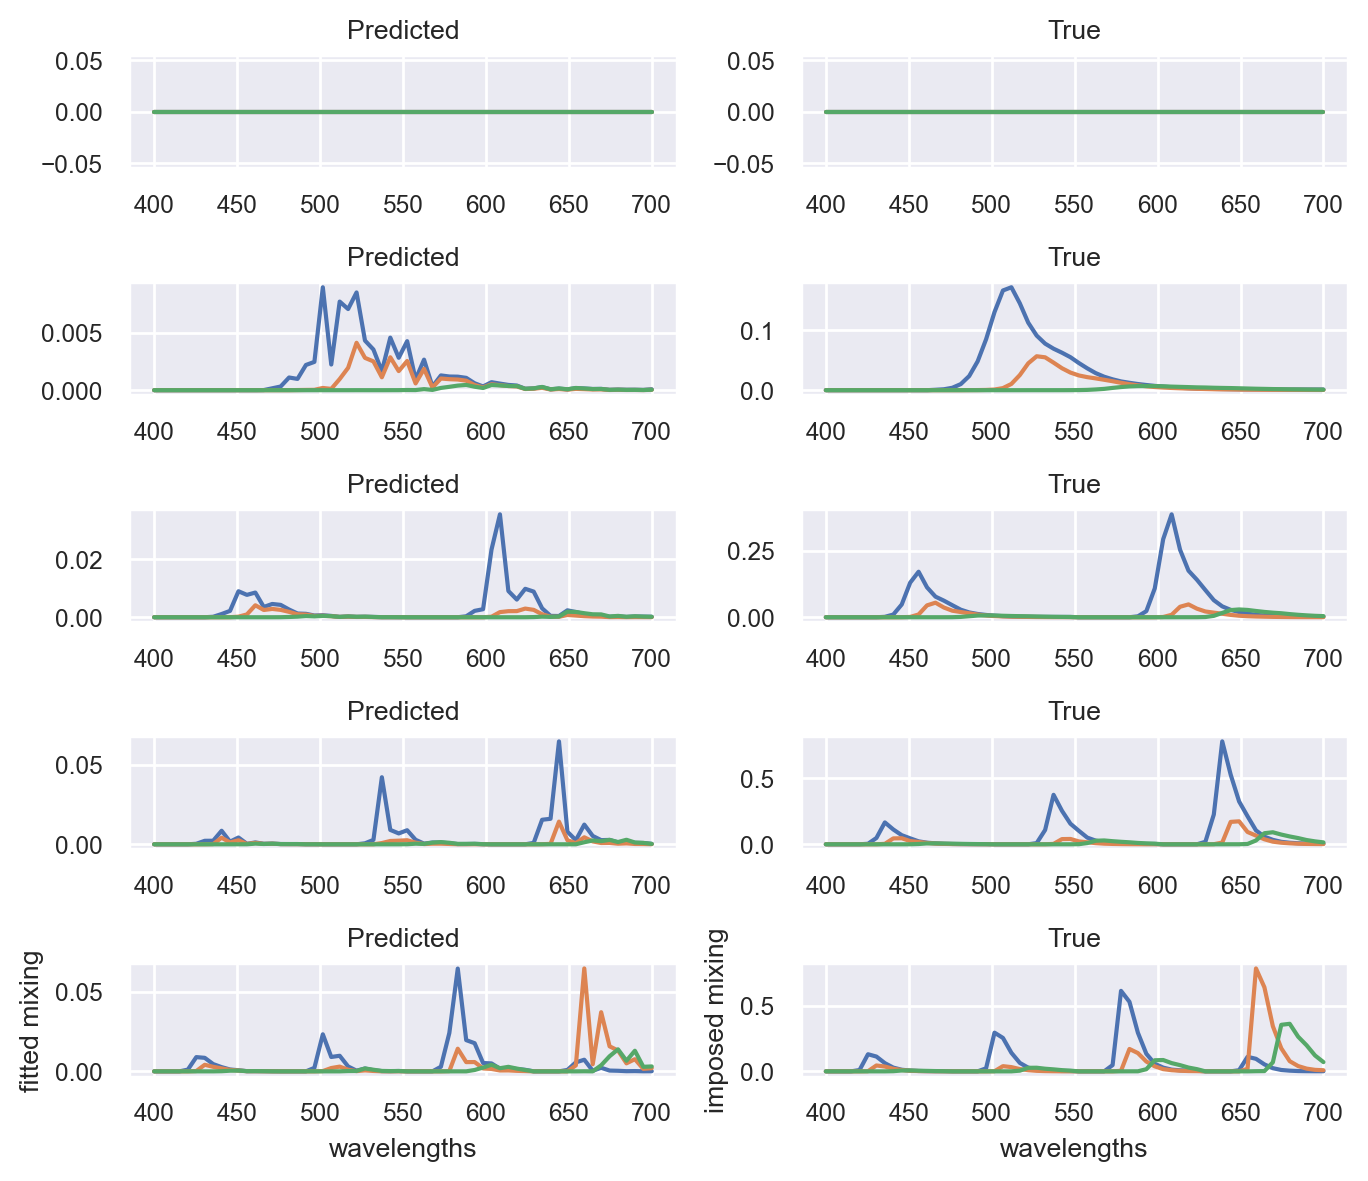

avg. L1 error: 0.01784883
avg. L2 error: 0.07184398


In [8]:
# Example with true, noisy
W_init = W_true.copy()
H_init = np.random.rand(W_init.shape[1],O_noisy.shape[1]) + 2.0

scale_factor = 1e1
t_start=0
t_end=20000
H_init = H_init[:,t_start:t_end]

model = NMF(n_components=3, init='custom',
            solver='mu', beta_loss='frobenius',
            tol=1e-10, max_iter=10000, random_state=None,
            alpha_W=0.0, alpha_H=0, l1_ratio=0.0,
            verbose=0, shuffle=False)

with timebudget('Fitting'):
    W_pred = model.fit_transform(O_noisy[:,t_start:t_end]*scale_factor, W=W_init, H=H_init)
H_pred = model.components_

fig, ax = plot_components(H_true[:,t_start:t_end], H_pred)
fig, ax = plot_mixing(L_arr, W_true, W_pred)
plt.show()

# errors
err = (O_noisy[:,t_start:t_end]*scale_factor - W_pred@H_pred)/scale_factor
print(f'avg. L1 error: {np.mean(np.abs(err)):.8f}')
print(f'avg. L2 error: {np.mean(np.abs(err**2)):.8f}')